# AQI Prediction

We will be using the below AQI scale from Open Weather since we are using the data collected from Open Weather API.

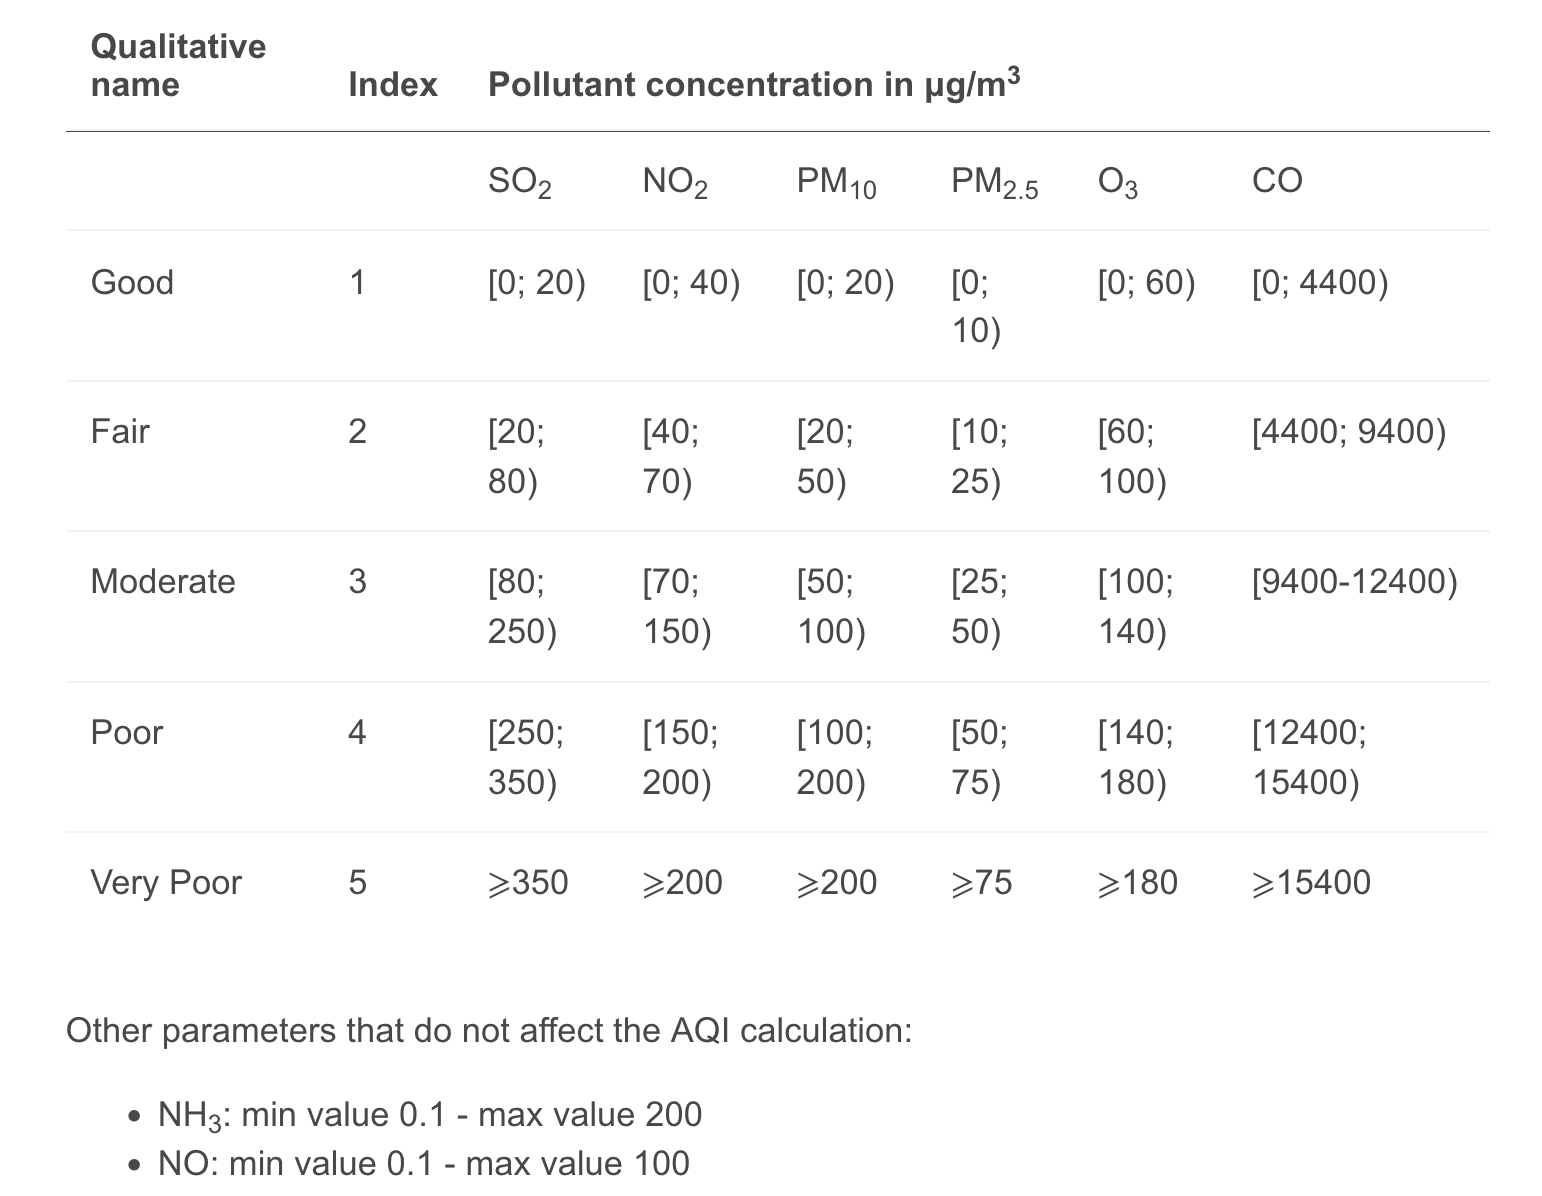

# Setup

In [23]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

# Read CSV File

In [24]:
import pandas as pd

bkk_df = pd.read_csv('/content/drive/MyDrive/air-quality-prediction/bkk-air-quality.csv')
bkk_df['datetime'] = pd.to_datetime(bkk_df['datetime'], format='%d-%m-%Y %H:%M:%S')
bkk_df = bkk_df.sort_values(by='datetime')
bkk_df.head()

,datetime,longitude,latitude,aqi,co,no,no2,so2,o3,pm2_5,pm10,nh3
0,2020-11-25 08:00:00,100.531,13.7625,5,3524.78,87.62,52.78,50.55,0.96,71.93,127.34,28.88
1,2020-11-25 09:00:00,100.531,13.7625,5,4272.46,105.50,56.89,58.17,3.13,78.78,147.39,36.99
2,2020-11-25 10:00:00,100.531,13.7625,5,4165.65,88.51,78.83,72.48,12.88,87.54,174.13,49.65
3,2020-11-25 11:00:00,100.531,13.7625,5,2109.53,14.75,80.88,57.22,27.54,59.83,116.86,37.49
4,2020-11-25 12:00:00,100.531,13.7625,4,1495.36,6.76,58.26,43.39,33.26,44.49,87.32,28.12


# Data Exploration

In [25]:
bkk_df.describe().transpose()

,count,mean,min,25%,50%,75%,max,std
datetime,32523,2022-10-11 05:39:05.761460992,2020-11-25 08:00:00,2021-10-31 02:30:00,2022-10-08 21:00:00,2023-09-19 15:30:00,2024-08-30 10:00:00,NaN
longitude,32523.0,100.531,100.531,100.531,100.531,100.531,100.531,0.0
latitude,32523.0,13.7625,13.7625,13.7625,13.7625,13.7625,13.7625,0.0
aqi,32523.0,4.405221,2.0,4.0,5.0,5.0,5.0,0.842323
co,32523.0,3941.82631,607.49,1735.69,2643.59,4646.3,34606.93,3707.657995
no,32523.0,84.660872,0.0,18.78,52.75,109.08,987.05,101.892696
no2,32523.0,62.263079,-9999.0,36.67,48.67,69.23,690.94,92.316054
so2,32523.0,66.461703,12.76,43.39,57.7,78.2,392.91,35.265768
o3,32523.0,30.43353,-9999.0,0.0,0.06,7.6,881.2,97.200219
pm2_5,32523.0,117.838727,9.41,44.88,74.21,133.21,1976.5,137.739717


In [26]:
bkk_df.isna().sum()

,0
datetime,0
longitude,0
latitude,0
aqi,0
co,0
no,0
no2,0
so2,0
o3,0
pm2_5,0


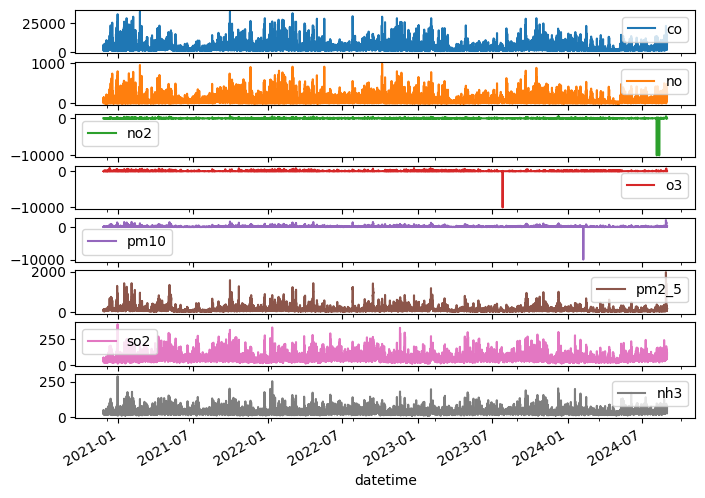

In [27]:
datetime = pd.to_datetime(bkk_df['datetime'], format='%d-%m-%Y %H:%M:%S')

plot_cols = ['co', 'no', 'no2', 'o3', 'pm10', 'pm2_5', 'so2', 'nh3']
plot_features = bkk_df[plot_cols]
plot_features.index = datetime
_ = plot_features.plot(subplots=True)

# Findings
From exploring these data, we can see that no2, o3 and pm10 has -9999 data which is impossible to have negative values.

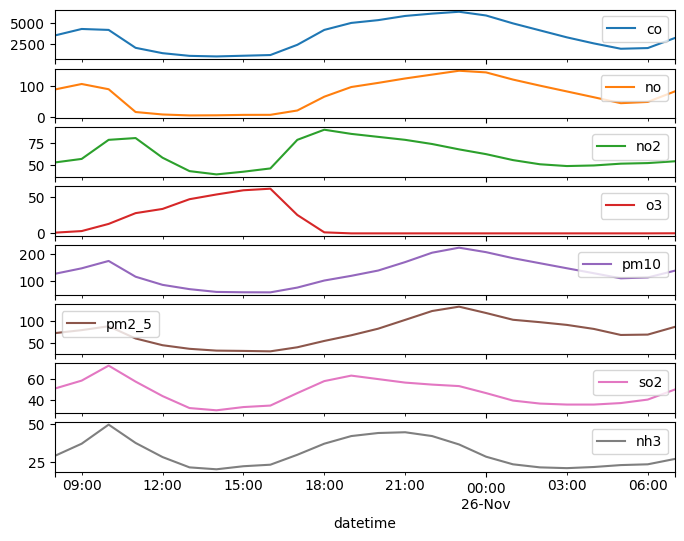

In [28]:
plot_features = bkk_df[plot_cols][:24]
plot_features.index = datetime[:24]
_ = plot_features.plot(subplots=True)

Remove the -9999 data points

In [29]:
bkk_df.loc[bkk_df['o3'] == -9999.0, 'o3'] = 0.0

bkk_df.loc[bkk_df['pm10'] == -9999.0, 'pm10'] = 0.0

bkk_df.loc[bkk_df['no2'] == -9999.0, 'no2'] = 0.0

# The above inplace edits are reflected in the DataFrame.
print(bkk_df['o3'].min())
print(bkk_df['pm10'].min())
print(bkk_df['no2'].min())

0.0
0.0
0.0


In [ ]:
df = bkk_df.drop(columns=['datetime', 'longitude', 'latitude'])
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
(corr
 .style
 .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(color='#f1f1f1')  # Color NaNs grey
 .format(precision=2))

,aqi,co,no,no2,so2,o3,pm2_5,pm10,nh3
aqi,nan,nan,nan,nan,nan,nan,nan,nan,nan
co,0.42,nan,nan,nan,nan,nan,nan,nan,nan
no,0.36,0.89,nan,nan,nan,nan,nan,nan,nan
no2,0.32,0.63,0.26,nan,nan,nan,nan,nan,nan
so2,0.38,0.63,0.53,0.65,nan,nan,nan,nan,nan
o3,0.15,-0.12,-0.29,0.04,0.04,nan,nan,nan,nan
pm2_5,0.41,0.80,0.54,0.70,0.58,0.21,nan,nan,nan
pm10,0.45,0.83,0.59,0.70,0.61,0.17,0.99,nan,nan
nh3,0.34,0.60,0.50,0.62,0.92,0.04,0.52,0.56,nan


In [30]:
date_time = pd.to_datetime(bkk_df.pop('datetime'), format='%Y-%m-%d %H:%M:%S')

timestamp_s = date_time.map(pd.Timestamp.timestamp)

day = 24*60*60
year = (365.2425)*day

bkk_df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
bkk_df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
bkk_df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
bkk_df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

# Remove the target aqi index from the independent variables

In [31]:
y = bkk_df['aqi']
bkk_df = bkk_df.drop(columns=['aqi'])
bkk_df.head(5)

,longitude,latitude,co,no,no2,so2,o3,pm2_5,pm10,nh3,Day sin,Day cos,Year sin,Year cos
0,100.531,13.7625,3524.78,87.62,52.78,50.55,0.96,71.93,127.34,28.88,8.660254e-01,-0.500000,-0.580944,0.813944
1,100.531,13.7625,4272.46,105.50,56.89,58.17,3.13,78.78,147.39,36.99,7.071068e-01,-0.707107,-0.580360,0.814360
2,100.531,13.7625,4165.65,88.51,78.83,72.48,12.88,87.54,174.13,49.65,5.000000e-01,-0.866025,-0.579776,0.814776
3,100.531,13.7625,2109.53,14.75,80.88,57.22,27.54,59.83,116.86,37.49,2.588190e-01,-0.965926,-0.579192,0.815191
4,100.531,13.7625,1495.36,6.76,58.26,43.39,33.26,44.49,87.32,28.12,1.011360e-11,-1.000000,-0.578608,0.815606


# Split the data



# Preprocess the data

In [32]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
X_scaled = scaler.fit_transform(bkk_df)

# Create Data Windows

In [33]:
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:(i + sequence_length), 1:])
        y.append(data[i + sequence_length, 0])
    return np.array(X), np.array(y)

In [34]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

scaled_data = np.column_stack((y.values, X_scaled))

sequence_length = 12
X, y = create_sequences(scaled_data, sequence_length)
y = to_categorical(y - 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

num_classes = y.shape[1]

model = Sequential([
    LSTM(64, activation='relu', input_shape=(X.shape[1], X.shape[2]), return_sequences=True),
    LSTM(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
]
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1, callbacks=callbacks)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
732/732 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.6400 - loss: 0.8854 - val_accuracy: 0.7544 - val_loss: 0.5083
Epoch 2/100
732/732 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.7657 - loss: 0.4914 - val_accuracy: 0.7727 - val_loss: 0.4704
Epoch 3/100
732/732 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.7683 - loss: 0.4714 - val_accuracy: 0.7726 - val_loss: 0.4716
Epoch 4/100
732/732 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.7789 - loss: 0.4572 - val_accuracy: 0.7840 - val_loss: 0.4481
Epoch 5/100
732/732 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.7888 - loss: 0.4382 - val_accuracy: 0.7900 - val_loss: 0.4325
Epoch 6/100
732/732 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.7925 - loss: 0.4307 - val_accuracy: 0.7837 - val_loss: 0.4512
Epoch 7/100
732/732 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.7983 - loss: 0.4224 - val_accuracy: 0.7943 - val_loss: 0.4253
Epoch 8/100
732/732 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.8027 - loss: 0

In [35]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

Test Loss: 0.32899197936058044, Test Accuracy: 0.8628536462783813


In [36]:
from sklearn.metrics import classification_report, confusion_matrix

predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1) + 1  # Add 1 to convert back to 1-5 range
actual_classes = np.argmax(y_test, axis=1) + 1

print(classification_report(actual_classes, predicted_classes))

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
              precision    recall  f1-score   support

           2       0.69      0.82      0.75        91
           3       0.77      0.76      0.77       471
           4       0.73      0.64      0.68       665
           5       0.93      0.96      0.95      2025

    accuracy                           0.86      3252
   macro avg       0.78      0.80      0.79      3252
weighted avg       0.86      0.86      0.86      3252



In [18]:
cm = confusion_matrix(actual_classes, predicted_classes)

ValueError: The number of FixedLocator locations (4), usually from a call to set_ticks, does not match the number of labels (5).

<Figure size 1000x800 with 0 Axes>

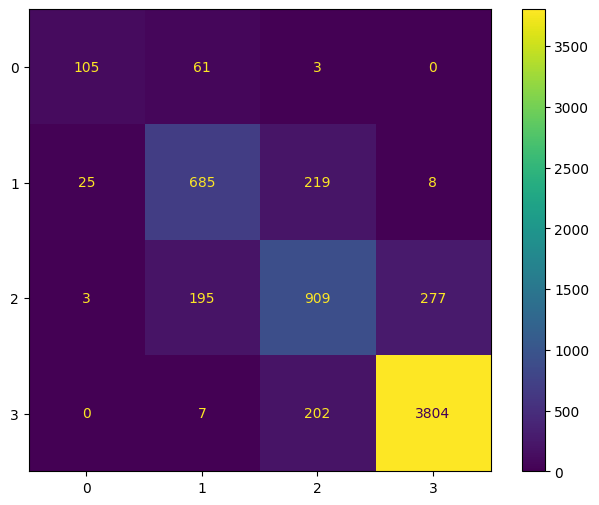

In [21]:
plt.figure(figsize=(10, 8))
cm = confusion_matrix(actual_classes, predicted_classes)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 2, 3, 4, 5])
disp.plot()
plt.show()

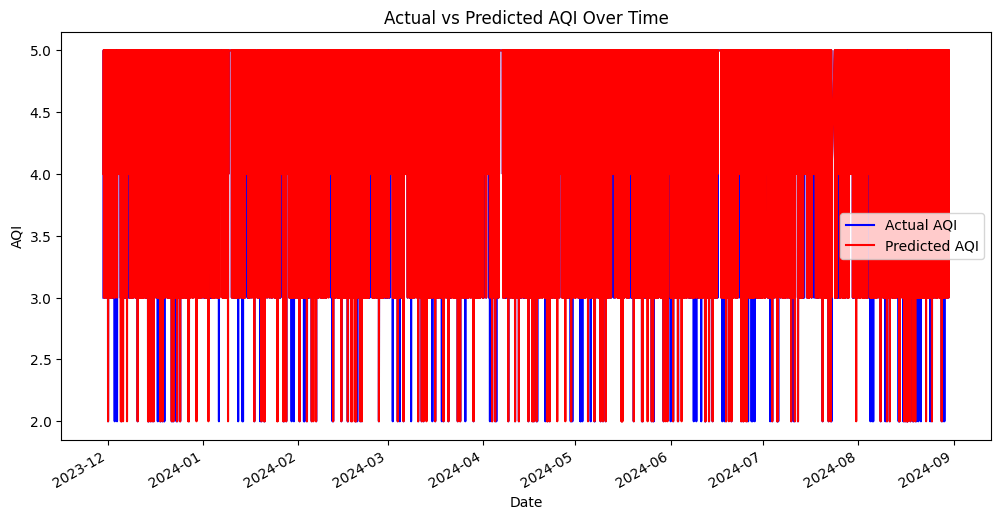

In [ ]:
results_df = pd.DataFrame({
    'datetime': datetime.iloc[-len(actual_classes):].values,
    'true_aqi': actual_classes,
    'predicted_aqi': predicted_classes
})

results_df = results_df.sort_values('datetime')

plt.figure(figsize=(12, 6))
plt.plot(results_df['datetime'], results_df['true_aqi'], label='Actual AQI', color='blue')
plt.plot(results_df['datetime'], results_df['predicted_aqi'], label='Predicted AQI', color='red')

plt.title('Actual vs Predicted AQI Over Time')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.legend()

plt.gcf().autofmt_xdate()

plt.show()

In [ ]:
results_df.to_csv('lstm_bkk_data.csv')

In [ ]:

# Print some results
for i in range(10):
    print(f'Predicted AQI: {predicted_classes[i]}, Actual AQI: {actual_classes[i]}')

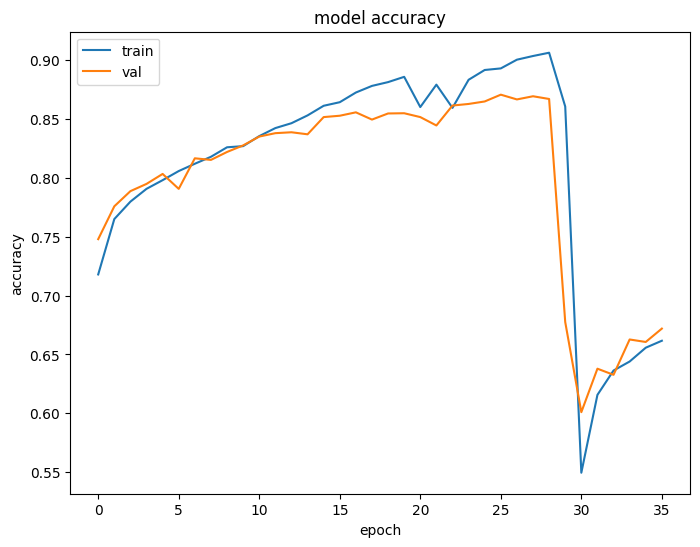

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

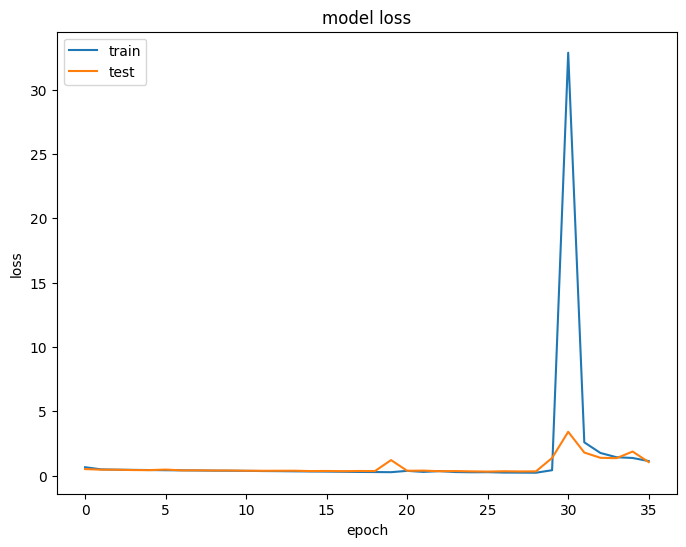

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model.save('lstm_best_accuracy_aqi_bkk.keras')